In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()   # select kaggle.json from your computer

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nisanthnoel","key":"d0a06967d3818327e1657f42d52f865a"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d abhinand05/crop-production-in-india

Dataset URL: https://www.kaggle.com/datasets/abhinand05/crop-production-in-india
License(s): other
  0% 0.00/1.96M [00:00<?, ?B/s]
100% 1.96M/1.96M [00:00<00:00, 661MB/s]


In [5]:
!unzip '*.zip'

import pandas as pd

# Adjust file name as needed (check after unzip)
df = pd.read_csv('crop_production.csv')
df.head()

Archive:  crop-production-in-india.zip
  inflating: crop_production.csv     


,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
0,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Arecanut,1254.0,2000.0
1,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Other Kharif pulses,2.0,1.0
2,Andaman and Nicobar Islands,NICOBARS,2000,Kharif,Rice,102.0,321.0
3,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Banana,176.0,641.0
4,Andaman and Nicobar Islands,NICOBARS,2000,Whole Year,Cashewnut,720.0,165.0


In [6]:
print(df.info())
print(df.describe())
print(df.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246091 entries, 0 to 246090
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   State_Name     246091 non-null  object 
 1   District_Name  246091 non-null  object 
 2   Crop_Year      246091 non-null  int64  
 3   Season         246091 non-null  object 
 4   Crop           246091 non-null  object 
 5   Area           246091 non-null  float64
 6   Production     242361 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 13.1+ MB
None
           Crop_Year          Area    Production
count  246091.000000  2.460910e+05  2.423610e+05
mean     2005.643018  1.200282e+04  5.825034e+05
std         4.952164  5.052340e+04  1.706581e+07
min      1997.000000  4.000000e-02  0.000000e+00
25%      2002.000000  8.000000e+01  8.800000e+01
50%      2006.000000  5.820000e+02  7.290000e+02
75%      2010.000000  4.392000e+03  7.023000e+03
max      2015.000000  8.5

In [7]:
import numpy as np

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", numeric_cols)

Numeric columns: ['Crop_Year', 'Area', 'Production']


In [8]:
def minmax_scale_manual(df, cols=None, feature_range=(0,1)):
    a, b = feature_range
    scaled_df = df.copy()
    if cols is None:
        cols = scaled_df.select_dtypes(include=[np.number]).columns.tolist()
    for c in cols:
        col = scaled_df[c].astype(float)
        minv, maxv = col.min(), col.max()
        if minv == maxv:
            scaled_df[c] = a  # constant column
        else:
            scaled_df[c] = ((col - minv) / (maxv - minv)) * (b - a) + a
    return scaled_df

scaled_df = minmax_scale_manual(df, numeric_cols)
scaled_df[numeric_cols].describe().loc[['min', 'max']]

,Crop_Year,Area,Production
min,0.0,0.0,0.0
max,1.0,1.0,1.0


In [9]:
# Group-wise Min–Max scaling by 'State_Name'
def groupwise_minmax_scale(df, group_col, cols=None, feature_range=(0,1)):
    a, b = feature_range
    scaled_df = df.copy()
    if cols is None:
        cols = scaled_df.select_dtypes(include=[np.number]).columns.tolist()

    # Apply scaling within each group
    for c in cols:
        scaled_df[c] = scaled_df.groupby(group_col)[c].transform(
            lambda x: ((x - x.min()) / (x.max() - x.min())) * (b - a) + a if x.max() != x.min() else a
        )
    return scaled_df

# Example: scale all numeric columns within each State_Name group
scaled_state_df = groupwise_minmax_scale(df, group_col='State_Name', cols=numeric_cols)
scaled_state_df.head()

,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
0,Andaman and Nicobar Islands,NICOBARS,0.0,Kharif,Arecanut,0.068162,2.804909e-05
1,Andaman and Nicobar Islands,NICOBARS,0.0,Kharif,Other Kharif pulses,0.000098,1.262272e-08
2,Andaman and Nicobar Islands,NICOBARS,0.0,Kharif,Rice,0.005534,4.500701e-06
3,Andaman and Nicobar Islands,NICOBARS,0.0,Whole Year,Banana,0.009557,8.988780e-06
4,Andaman and Nicobar Islands,NICOBARS,0.0,Whole Year,Cashewnut,0.039131,2.312763e-06


In [10]:
# Separate categorical & numeric columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

Categorical columns: ['State_Name', 'District_Name', 'Season', 'Crop']
Numeric columns: ['Crop_Year', 'Area', 'Production']


In [11]:

from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le  # store encoder for inverse_transform later if needed

print("✅ Label encoding complete")
df_encoded.head()

✅ Label encoding complete


,State_Name,District_Name,Crop_Year,Season,Crop,Area,Production
0,0,427,2000,1,2,1254.0,2000.0
1,0,427,2000,1,74,2.0,1.0
2,0,427,2000,1,95,102.0,321.0
3,0,427,2000,4,7,176.0,641.0
4,0,427,2000,4,22,720.0,165.0


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = df_encoded.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

print("✅ Standard scaling complete")
df_scaled[numeric_cols].describe().loc[['mean', 'std']]

✅ Standard scaling complete


,Crop_Year,Area,Production
mean,1.510321e-14,-1.778587e-17,1.451951e-17
std,1.000002e+00,1.000002e+00,1.000002e+00


In [13]:
minmax_df = minmax_scale_manual(df, numeric_cols)
minmax_df.to_csv("dataset_minmax.csv", index=False)

In [14]:
state_minmax_df = groupwise_minmax_scale(df, group_col='State_Name', cols=numeric_cols)
state_minmax_df.to_csv("dataset_state_minmax.csv", index=False)

In [15]:
df_label_encoded = df.copy()
for col in categorical_cols:
    le = LabelEncoder()
    df_label_encoded[col] = le.fit_transform(df_label_encoded[col].astype(str))
df_label_encoded.to_csv("dataset_label_encoded.csv", index=False)

In [16]:
scaler = StandardScaler()
df_standard_scaled = df_label_encoded.copy()
df_standard_scaled[numeric_cols] = scaler.fit_transform(df_standard_scaled[numeric_cols])
df_standard_scaled.to_csv("dataset_standard_scaled.csv", index=False)

In [17]:
df_mm_le = minmax_scale_manual(df, numeric_cols)
for col in categorical_cols:
    le = LabelEncoder()
    df_mm_le[col] = le.fit_transform(df_mm_le[col].astype(str))
df_mm_le.to_csv("dataset_minmax_labelencoded.csv", index=False)

In [18]:
df_std_le = df_label_encoded.copy()
df_std_le[numeric_cols] = scaler.fit_transform(df_std_le[numeric_cols])
df_std_le.to_csv("dataset_standard_labelencoded.csv", index=False)

In [19]:
datasets = [
    "dataset_minmax.csv",
    "dataset_state_minmax.csv",
    "dataset_label_encoded.csv",
    "dataset_standard_scaled.csv",
    "dataset_minmax_labelencoded.csv",
    "dataset_standard_labelencoded.csv"
]

for d in datasets:
    print("Saved:", d)

Saved: dataset_minmax.csv
Saved: dataset_state_minmax.csv
Saved: dataset_label_encoded.csv
Saved: dataset_standard_scaled.csv
Saved: dataset_minmax_labelencoded.csv
Saved: dataset_standard_labelencoded.csv


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split

df_model = pd.read_csv("dataset_standard_labelencoded.csv")
df_model = df_model.dropna(subset=['Production'])
df_model = df_model.fillna(0)

target_col = 'Production'
X = df_model.drop(columns=[target_col])
y = df_model[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Linear Regression → MAE: 0.09253317485001462 RMSE: 1.1716074074984064 R²: 0.006368027228821127


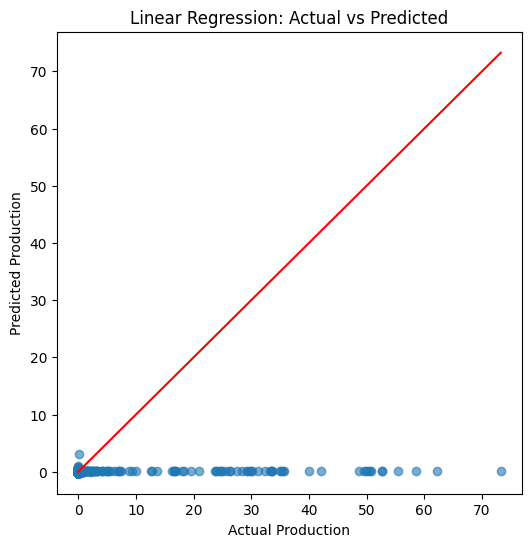

In [21]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression → MAE:", mae_lr, "RMSE:", rmse_lr, "R²:", r2_lr)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lr, alpha=0.6)
plt.xlabel("Actual Production")
plt.ylabel("Predicted Production")
plt.title("Linear Regression: Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.show()


Random Forest → MAE: 0.008015400872138626 RMSE: 0.30730956416107447 R²: 0.9316381993821385


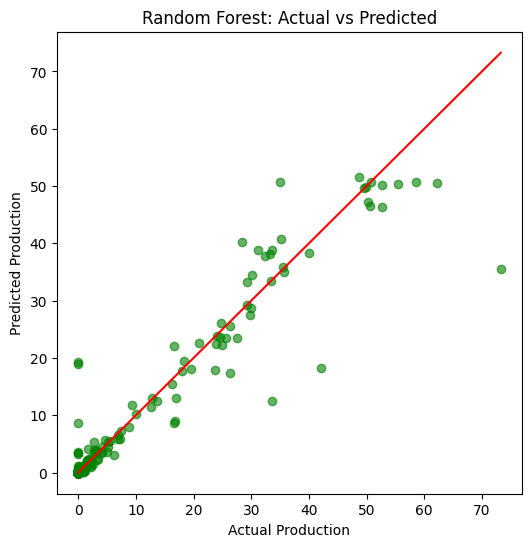

In [22]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=20, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest → MAE:", mae_rf, "RMSE:", rmse_rf, "R²:", r2_rf)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='green')
plt.xlabel("Actual Production")
plt.ylabel("Predicted Production")
plt.title("Random Forest: Actual vs Predicted")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.show()

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((name, mae, rmse, r2))

results_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R2"])
print(results_df.sort_values(by="R2", ascending=False))


              Model       MAE      RMSE        R2
1      RandomForest  0.008151  0.310537  0.930195
2      DecisionTree  0.009138  0.465975  0.842824
3  GradientBoosting  0.042649  0.603597  0.736273
0  LinearRegression  0.092533  1.171607  0.006368


In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

categorical_cols = ['State_Name', 'District_Name', 'Season', 'Crop']
numeric_cols = ['Crop_Year', 'Area']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, max_categories=20), categorical_cols),
    ('num', StandardScaler(), numeric_cols)
])
fast_rf = RandomForestRegressor(
    n_estimators=50,
    max_depth=10,
    min_samples_split=5,
    n_jobs=-1,
    random_state=42
)

model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', fast_rf)
])

model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                max_categories=20,
                                                                sparse_output=False),
                                                  ['State_Name',
                                                   'District_Name', 'Season',
                                                   'Crop']),
                                                 ('num', StandardScaler(),
                                                  ['Crop_Year', 'Area'])])),
                ('model',
                 RandomForestRegressor(max_depth=10, min_samples_split=5,
                                       n_estimators=50, n_jobs=-1,
                                       random_state=42))])

In [29]:
sample_input = pd.DataFrame([{
    "State_Name": "Maharashtra",
    "District_Name": "Pune",
    "Crop_Year": 2015,
    "Season": "Kharif",
    "Crop": "Rice",
    "Area": 1000
}])

predicted_value = model_pipeline.predict(sample_input)
print("Predicted Production:", predicted_value[0])


Predicted Production: 0.25240326089655635


In [30]:
df = df[df['Production'] > 0].copy()
df = df.sort_values(by=['State_Name', 'Crop', 'Crop_Year'])
df.reset_index(drop=True, inplace=True)


In [31]:
import pandas as pd

df = pd.read_csv("/content/crop-production-in-india.zip")

print(df.head())


                    State_Name District_Name  Crop_Year       Season  \
0  Andaman and Nicobar Islands      NICOBARS       2000  Kharif        
1  Andaman and Nicobar Islands      NICOBARS       2000  Kharif        
2  Andaman and Nicobar Islands      NICOBARS       2000  Kharif        
3  Andaman and Nicobar Islands      NICOBARS       2000  Whole Year    
4  Andaman and Nicobar Islands      NICOBARS       2000  Whole Year    

                  Crop    Area  Production  
0             Arecanut  1254.0      2000.0  
1  Other Kharif pulses     2.0         1.0  
2                 Rice   102.0       321.0  
3               Banana   176.0       641.0  
4            Cashewnut   720.0       165.0  


In [32]:
df = df[df['Production'] > 0].copy()
df = df.dropna(subset=['Crop_Year'])


In [33]:
df['Date'] = pd.to_datetime(df['Crop_Year'], format='%Y', errors='coerce')
df = df.dropna(subset=['Date'])
df = df.set_index('Date')


In [34]:
df = df.sort_index()
print(df.index.min(), "→", df.index.max())


1997-01-01 00:00:00 → 2015-01-01 00:00:00


In [35]:
subset = df[(df['Crop'] == 'Rice') & (df['State_Name'] == 'Maharashtra')]
ts = subset.resample('YE')['Production'].sum()
ts = ts.asfreq('YE').interpolate()

In [36]:
ts = ts.dropna().astype(float)


In [37]:
print("Length of ts:", len(ts))
print(ts.head())

Length of ts: 18
Date
1997-12-31    2330646.0
1998-12-31    2467600.0
1999-12-31    2549300.0
2000-12-31    1929700.0
2001-12-31    2651200.0
Freq: YE-DEC, Name: Production, dtype: float64


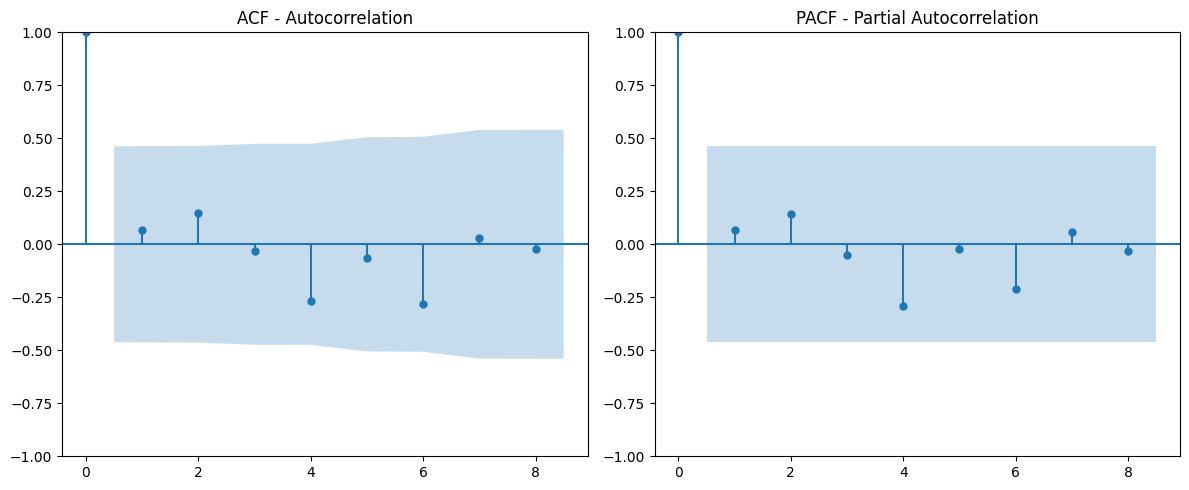

In [38]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plot_acf(ts, ax=plt.gca(), lags=8)
plt.title('ACF - Autocorrelation')

plt.subplot(1,2,2)
plot_pacf(ts, ax=plt.gca(), lags=8)
plt.title('PACF - Partial Autocorrelation')

plt.tight_layout()
plt.show()


In [39]:
from statsmodels.tsa.stattools import adfuller, kpss

adf_result = adfuller(ts.dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

kpss_result = kpss(ts.dropna(), regression='c')
print("\nKPSS Statistic:", kpss_result[0])
print("p-value:", kpss_result[1])


ADF Statistic: -3.5384835474974277
p-value: 0.0070520425751628615

KPSS Statistic: 0.20472219118818094
p-value: 0.1


/tmp/ipython-input-4157956116.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(ts.dropna(), regression='c')


In [40]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd


In [41]:
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]


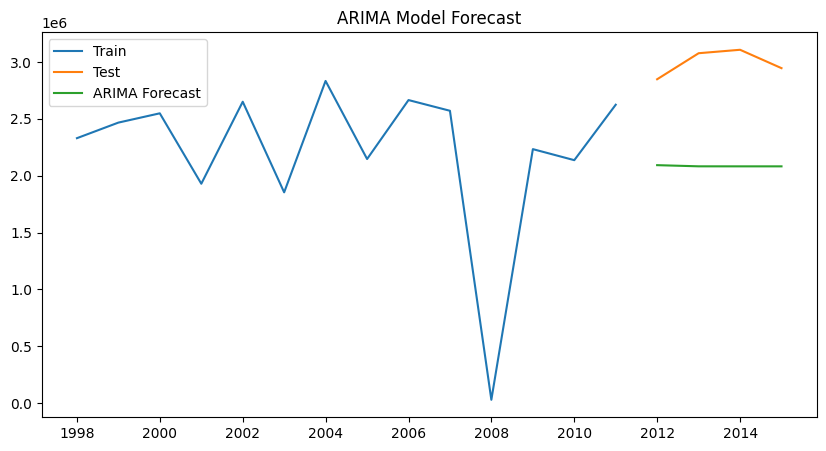

In [42]:
model_arima = ARIMA(train, order=(1, 1, 1))
fit_arima = model_arima.fit()
forecast_arima = fit_arima.forecast(steps=len(test))

plt.figure(figsize=(10,5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast_arima, label='ARIMA Forecast')
plt.legend()
plt.title('ARIMA Model Forecast')
plt.show()


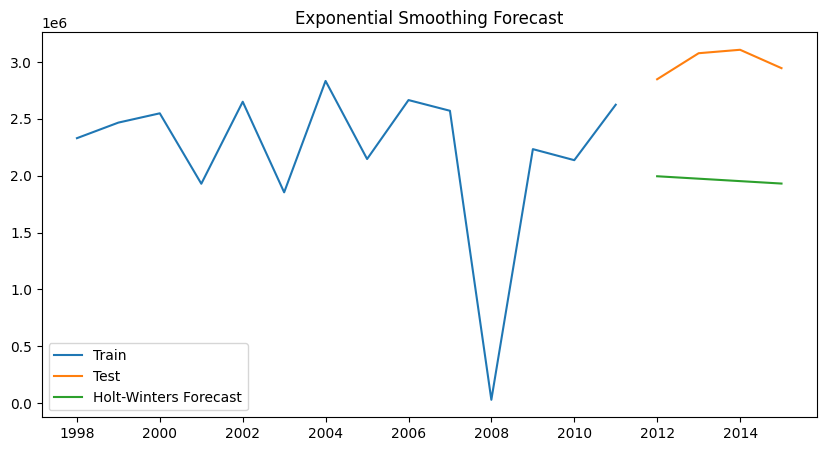

In [43]:
model_hw = ExponentialSmoothing(train, seasonal=None, trend='add')
fit_hw = model_hw.fit()
forecast_hw = fit_hw.forecast(len(test))

plt.figure(figsize=(10,5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast_hw, label='Holt-Winters Forecast')
plt.legend()
plt.title('Exponential Smoothing Forecast')
plt.show()


In [44]:
!pip uninstall -y prophet fbprophet
!pip install prophet --quiet


Found existing installation: prophet 1.1.7
Uninstalling prophet-1.1.7:
  Successfully uninstalled prophet-1.1.7
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 95.6 MB/s eta 0:00:00


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 10.
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


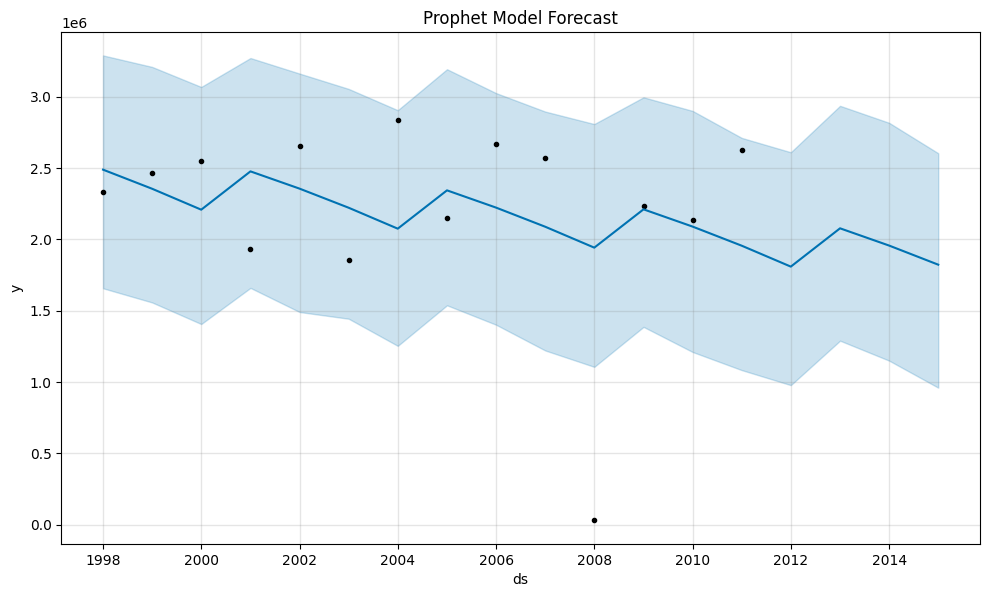

In [45]:
from prophet import Prophet

prophet_df = ts.reset_index()
prophet_df.columns = ['ds', 'y']

train_prophet = prophet_df.iloc[:train_size]
test_prophet = prophet_df.iloc[train_size:]

model_prophet = Prophet()
model_prophet.fit(train_prophet)

future = model_prophet.make_future_dataframe(periods=len(test), freq='Y')
forecast_prophet = model_prophet.predict(future)

model_prophet.plot(forecast_prophet)
plt.title('Prophet Model Forecast')
plt.show()


In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(true, pred, name):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    print(f"{name} → RMSE: {rmse:.2f}, MAE: {mae:.2f}")

evaluate_model(test, forecast_arima, "ARIMA")
evaluate_model(test, forecast_hw, "Holt-Winters")
evaluate_model(test, forecast_prophet['yhat'][-len(test):].values, "Prophet")


ARIMA → RMSE: 916417.20, MAE: 910045.85
Holt-Winters → RMSE: 1038350.47, MAE: 1031994.74
Prophet → RMSE: 1081591.86, MAE: 1079856.45


In [47]:
!pip uninstall -y prophet fbprophet
!pip install prophet --quiet

from prophet import Prophet
import joblib


Found existing installation: prophet 1.2.1
Uninstalling prophet-1.2.1:
  Successfully uninstalled prophet-1.2.1


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 10.
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


<Figure size 1000x500 with 0 Axes>

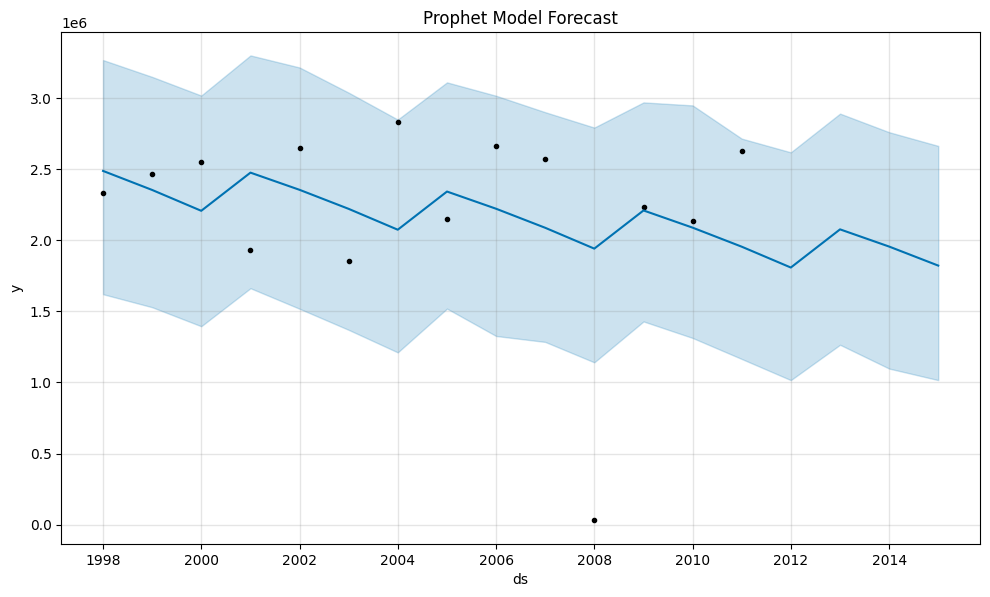

In [48]:
prophet_df = ts.reset_index()
prophet_df.columns = ['ds', 'y']

train_prophet = prophet_df.iloc[:train_size]
test_prophet  = prophet_df.iloc[train_size:]

model_prophet = Prophet()
model_prophet.fit(train_prophet)

future = model_prophet.make_future_dataframe(periods=len(test), freq='Y')
forecast_prophet = model_prophet.predict(future)

plt.figure(figsize=(10,5))
model_prophet.plot(forecast_prophet)
plt.title("Prophet Model Forecast")
plt.show()


In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(true, pred, name):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    print(f"{name:15s}  RMSE: {rmse:.2f}   MAE: {mae:.2f}")

evaluate_model(test, forecast_arima, "ARIMA")
evaluate_model(test, forecast_hw, "Holt-Winters")
evaluate_model(test, forecast_prophet['yhat'][-len(test):].values, "Prophet")


ARIMA            RMSE: 916417.20   MAE: 910045.85
Holt-Winters     RMSE: 1038350.47   MAE: 1031994.74
Prophet          RMSE: 1081591.86   MAE: 1079856.45


In [50]:
joblib.dump(model_pipeline, "best_regression_model.pkl")
joblib.dump(model_prophet, "prophet_forecast_model.pkl")

print("✅ Models exported successfully!")


✅ Models exported successfully!


In [51]:
loaded_model = joblib.load("prophet_forecast_model.pkl")
future = loaded_model.make_future_dataframe(periods=5, freq='Y')
forecast = loaded_model.predict(future)
forecast.tail()


/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
14,2011-12-31,-9.248905e+05,9.604927e+05,2.574556e+06,-9.248905e+05,-9.248905e+05,2.733104e+06,2.733104e+06,2.733104e+06,2.733104e+06,2.733104e+06,2.733104e+06,0.0,0.0,0.0,1.808214e+06
15,2012-12-31,-9.582139e+05,1.250160e+06,2.869666e+06,-9.582140e+05,-9.582139e+05,3.034888e+06,3.034888e+06,3.034888e+06,3.034888e+06,3.034888e+06,3.034888e+06,0.0,0.0,0.0,2.076674e+06
16,2013-12-31,-9.914463e+05,1.135779e+06,2.813207e+06,-9.914464e+05,-9.914463e+05,2.947139e+06,2.947139e+06,2.947139e+06,2.947139e+06,2.947139e+06,2.947139e+06,0.0,0.0,0.0,1.955692e+06
17,2014-12-31,-1.024679e+06,9.943818e+05,2.711218e+06,-1.024679e+06,-1.024679e+06,2.846503e+06,2.846503e+06,2.846503e+06,2.846503e+06,2.846503e+06,2.846503e+06,0.0,0.0,0.0,1.821825e+06
18,2015-12-31,-1.057911e+06,9.201454e+05,2.458735e+06,-1.057911e+06,-1.057911e+06,2.733104e+06,2.733104e+06,2.733104e+06,2.733104e+06,2.733104e+06,2.733104e+06,0.0,0.0,0.0,1.675193e+06


In [52]:
future = loaded_model.make_future_dataframe(periods=5, freq='YE')
forecast = loaded_model.predict(future)
forecast.tail()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
14,2011-12-31,-9.248905e+05,9.245825e+05,2.565424e+06,-9.248905e+05,-9.248905e+05,2.733104e+06,2.733104e+06,2.733104e+06,2.733104e+06,2.733104e+06,2.733104e+06,0.0,0.0,0.0,1.808214e+06
15,2012-12-31,-9.582139e+05,1.313637e+06,2.938425e+06,-9.582140e+05,-9.582139e+05,3.034888e+06,3.034888e+06,3.034888e+06,3.034888e+06,3.034888e+06,3.034888e+06,0.0,0.0,0.0,2.076674e+06
16,2013-12-31,-9.914463e+05,1.153187e+06,2.762261e+06,-9.914464e+05,-9.914463e+05,2.947139e+06,2.947139e+06,2.947139e+06,2.947139e+06,2.947139e+06,2.947139e+06,0.0,0.0,0.0,1.955692e+06
17,2014-12-31,-1.024679e+06,9.932905e+05,2.554420e+06,-1.024679e+06,-1.024679e+06,2.846503e+06,2.846503e+06,2.846503e+06,2.846503e+06,2.846503e+06,2.846503e+06,0.0,0.0,0.0,1.821825e+06
18,2015-12-31,-1.057911e+06,8.126150e+05,2.459106e+06,-1.057911e+06,-1.057911e+06,2.733104e+06,2.733104e+06,2.733104e+06,2.733104e+06,2.733104e+06,2.733104e+06,0.0,0.0,0.0,1.675193e+06


In [53]:
from prophet.plot import plot_plotly

fig = plot_plotly(loaded_model, forecast)
fig.update_layout(title="Future Crop Yield Forecast", xaxis_title="Year", yaxis_title="Predicted Production")
fig.show()
